In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imghdr
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

# gpus

2. Remove dodgy images

In [68]:
data_dir = 'D:/TLCN/EventData/'

image_type = ['jpeg','jpg', 'png']

In [4]:

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_type: 
                print('Image not in image type {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


3. Preprocess

In [3]:
# img = Image.open('D:/TLCN/EventData/Concert/237.jpg')
# img = Image.open('D:/TLCN/EventData/Concert/_97250079_gettyimages-450231854.jpg')
# i = Image.open('D:/TLCN/EventData/Concert/_97250079_gettyimages-450231854.jpg')
# # image_data = i.load()
# # height,width = i.size
# # for loop1 in range(height):
# #     for loop2 in range(width):
# #         r,g,b = image_data[loop1,loop2]
# #         image_data[loop1,loop2] = r,0,b
# threshold_img = threshold(i)
# img_opened = image_opening(threshold_img)
# img_processed = segment(i, img_opened)
# img_processed = img_processed.convert('RGB')
# img_processed.show()
# # i.show()

In [6]:
# def erosion(cycles, image):
#     for i in range(cycles):
#         erosion_img = image.filter(ImageFilter.MinFilter(3))
#     return erosion_img

In [7]:
# def dilation(cycles, image):
#     for i in range(cycles):
#         dilation_img = image.filter(ImageFilter.MaxFilter(3))
#     return dilation_img

In [8]:
# def threshold(image):
#     gray_img = image.convert('L')
#     threshold = 100
#     img_threshold = gray_img.point(lambda x: 255 if x > threshold else 0)
#     return img_threshold
# img_threshold = threshold(img)
# # img_threshold.show()

In [9]:
# def image_opening(threshold_img):
#     erosion_img = erosion(20,threshold_img)
#     dilation_img = dilation(50,erosion_img)
#     # dilation_img = dilation(80,threshold_img)
#     # opened_img = erosion(10,dilation_img)
#     return dilation_img
# dilation_img = image_opening(img_threshold)
# dilation_img.show()

In [10]:
# def segment(image, img_opened):
#     mask = img_opened.convert("L")
#     mask = mask.filter(ImageFilter.BoxBlur(20))
#     blank = img.point(lambda _: 0)
#     img_segmented = Image.composite(image, blank, mask)
#     return img_segmented

# img_segment= segment(img, dilation_img)
# img_segment.show()

In [11]:
# def segment(image, label):
#     img_threshold = threshold(image)
#     img_opened = image_opening(img_threshold)
#     mask = img_opened.convert("L")
#     mask = mask.filter(ImageFilter.BoxBlur(20))
#     blank = img.point(lambda _: 0)
#     img_segmented = Image.composite(image, blank, mask)
#     return img_segmented, label


In [12]:
# store_dir = "D:/TLCN/EventDataProcessed/Concert/"
# for root, directory, file in os.walk('D:/TLCN/EventData/Concert/'):
#     for f in file: 
#         if os.path.isfile(os.path.join(root,f)):
#             img = Image.open(os.path.join(root,f))
#             threshold_img = threshold(img)
#             img_opened = image_opening(threshold_img)
#             img_processed = segment(img, img_opened)
#             img_processed = img_processed.convert('RGB')
#             img_processed.save(store_dir+f)

4. Load Data

In [21]:
# Y = tf.keras.utils.to_categorical(Y, NUM_CLASSES, dtype='int')

In [69]:
tf.random.set_seed(80)
data = tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(224, 224), seed=68)
print('There are 4 classes in dataset: {}'.format(data.class_names))

Found 4452 files belonging to 4 classes.
There are 4 classes in dataset: ['Concert', 'Graduation', 'Meeting', 'WhiteWedding']


In [126]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
type(data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [127]:
# fig, ax = plt.subplots(ncols=5, figsize=(20,20))
# for idx, img in enumerate(batch[0][:5]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

5. Split Data

In [70]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [71]:
train = train.shuffle(buffer_size = 80)
test = test.shuffle(buffer_size = 80)
val = val.shuffle(buffer_size = 80)

6. Data Augmention 

In [72]:
tf.random.set_seed(80)
def image_augmentation(image, label): # to improve overfitting
    # if tf.random.uniform((), minval=0, maxval=1) > 0.8:
    image = tf.image.random_brightness(image, max_delta = 0.3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower = 0, upper = 1.8)
    return image, label

In [73]:
tf.random.set_seed(80)
train = train.map(image_augmentation)

In [74]:
# tf.random.uniform(([10]), minval=0, maxval=1)

7. Scale Data

In [75]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [76]:
train = train.map(lambda x,y: (normalization_layer(x), y))
val = val.map(lambda x,y: (normalization_layer(x), y))
test = test.map(lambda x,y: (normalization_layer(x), y))

8. Build Deep Learning Model

In [77]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet152, InceptionV3, VGG16

input = Input(shape=(224,224,3))

In [49]:
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model = Sequential(base_model.layers[:-1])

# for layer in model.layers:
#     layer.trainable = False

# model.add(Dense(units=2048, activation='relu', name='fc1'))
# model.add(Dropout(0.5))
# model.add(Dense(units=2048, activation='relu', name='fc2'))
# model.add(Dropout(0.5))
# model.add(Dense(units=5, activation='softmax', name='output'))

# logdir='D:/TLCN/Event_Image_Classification/logsTranferModel'
# def callback():
#     return[
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
#     tf.keras.callbacks.TensorBoard(log_dir=logdir)]

# # checkpoint = ModelCheckpoint(filepath='D:/TLCN/Event_Image_Classification/EventClassificationBestModel.h5',save_best_only=True)

# model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
# hist = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val,Y_val), callbacks= callback())

In [50]:
# #CNN_proposed_model
# model = Sequential()
# model.add(Input(shape = (224,224,3)))
# # block 1
# #Convolutional layer 1
# model.add(Conv2D(64, (3,3), 1,padding= 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2, strides =(2,2)))

# # block 2
# # Convolutional layer 2
# model.add(Conv2D(128, (3,3), 1 ,padding= 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2, strides =(2,2)))

# # block 3
# # Convolutional layer 3
# model.add(Conv2D(256, (3,3), 1 ,padding= 'same'))
# model.add(Activation('relu'))
# # Convolutional layer 4
# model.add(Conv2D(256, (3,3), 1 ,padding= 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2, strides =(2,2)))

# #block 4
# # Convolutional layer 5
# model.add(Conv2D(512, (3,3), 1 ,padding= 'same'))
# model.add(Activation('relu'))
# model.add(Conv2D(512, (3,3), 1 ,padding= 'same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2, strides =(2,2)))

# # Flatten layer
# model.add(Flatten())

# # Fully connected layer 1
# model.add(Dense(1024,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'))
# model.add(Dropout(0.5))
# # Fully connected layer 2
# model.add(Dense(1024,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation='relu'))
# model.add(Dropout(0.5))
# # Output layer
# model.add(Dense(4, activation='softmax'))

8.1. Get output of Pretrained models

In [78]:
#Restnet152 
Pretrained_model_1 = ResNet152(weights='imagenet', include_top=False, input_tensor=input)
for layer in Pretrained_model_1.layers:
    layer.trainable = False
#get base model output
resnet_output = Pretrained_model_1.output
# flatten the output to a dimension
resnet_flatten = Flatten()(resnet_output)
resnet_fc1 = Dense(2048, activation='relu')(resnet_flatten)
resnet_dropout1 = Dropout(0.5)(resnet_fc1)
resnet_fc2 = Dense(2048, activation='relu')(resnet_dropout1)
resnet_dropout2 = Dropout(0.5)(resnet_fc2)

In [79]:
#InceptionV3
InceptionV3_Pretrained = InceptionV3(weights='imagenet', include_top=False, input_tensor=input)
for layer in InceptionV3_Pretrained.layers:
    layer.trainable = False
#get base model output
inception_output = InceptionV3_Pretrained.output
# flatten the output to a dimension
inception_flatten = Flatten()(inception_output)
inception_fc1 = Dense(2048, activation='relu')(inception_flatten)
inception_dropout1 = Dropout(0.5)(inception_fc1)
inception_fc2 = Dense(2048, activation='relu')(inception_dropout1)
inception_dropout2 = Dropout(0.5)(inception_fc2)

In [80]:
#VGG16
VGG16_Pretrained = VGG16(weights='imagenet', include_top=False, input_tensor=input)
for layer in VGG16_Pretrained.layers:
    layer.trainable = False
#get base model output
VGG16_output = VGG16_Pretrained.output
# flatten the output to a dimension
VGG16_flatten = Flatten()(VGG16_output)
VGG16_fc1 = Dense(2048, activation='relu')(VGG16_flatten)
VGG16_dropout1 = Dropout(0.5)(VGG16_fc1)
VGG16_fc2 = Dense(2048, activation='relu')(VGG16_dropout1)
VGG16_dropout2 = Dropout(0.5)(VGG16_fc2)

8.2. Concatenate 2 pretrained models

In [81]:
#concatenate model
concatenated = Concatenate()([VGG16_dropout2, inception_dropout2])
bn = BatchNormalization()(concatenated)
hidden_layer = Dense(4096, kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = 'relu')(bn)
dropout = Dropout(0.5)(hidden_layer)
output = Dense(4, activation='softmax')(dropout)

Inception_VGG16_model = Model(inputs=input, outputs=output)

In [82]:
#concatenate model
concatenated2 = Concatenate()([resnet_dropout2, inception_dropout2])
bn2 = BatchNormalization()(concatenated2)
hidden_layer2 = Dense(4096, kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = 'relu')(bn2)
dropout2 = Dropout(0.5)(hidden_layer2)
output2 = Dense(4, activation='softmax')(dropout2)

Resnet152_Inception_model = Model(inputs=input, outputs=output2)

8.3. Build and compile concatenated model

In [83]:
logdir='D:/TLCN/Event_Image_Classification/logs'
def callback():
    return[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=8),
    tf.keras.callbacks.TensorBoard(log_dir=logdir)]

checkpoint = ModelCheckpoint(filepath='D:/TLCN/Event_Image_Classification/EventClassificationBestModel.h5',save_best_only=True)

Inception_VGG16_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
Inception_VGG16_hist = Inception_VGG16_model.fit(train, epochs=40, validation_data=val, callbacks= [callback(),checkpoint])

Epoch 1/40
98/98 [==============================] - 657s 6s/step - loss: 5.9910 - accuracy: 0.6406 - val_loss: 4.4831 - val_accuracy: 0.9219
Epoch 2/40
98/98 [==============================] - 620s 6s/step - loss: 4.7671 - accuracy: 0.7640 - val_loss: 3.8106 - val_accuracy: 0.8929
Epoch 3/40
98/98 [==============================] - 635s 6s/step - loss: 3.9406 - accuracy: 0.7720 - val_loss: 3.2921 - val_accuracy: 0.8817
Epoch 4/40
98/98 [==============================] - 627s 6s/step - loss: 3.1850 - accuracy: 0.8208 - val_loss: 2.6143 - val_accuracy: 0.9129
Epoch 5/40
98/98 [==============================] - 623s 6s/step - loss: 2.6090 - accuracy: 0.8527 - val_loss: 2.1462 - val_accuracy: 0.9353
Epoch 6/40
98/98 [==============================] - 624s 6s/step - loss: 2.1499 - accuracy: 0.8587 - val_loss: 1.7675 - val_accuracy: 0.9353
Epoch 7/40
98/98 [==============================] - 624s 6s/step - loss: 1.8022 - accuracy: 0.8766 - val_loss: 1.7244 - val_accuracy: 0.8438
Epoch 8/40
98

In [89]:
logdir='D:/TLCN/Event_Image_Classification/logs'
def callback():
    return[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=8),
    tf.keras.callbacks.TensorBoard(log_dir=logdir)]

checkpoint = ModelCheckpoint(filepath='D:/TLCN/Event_Image_Classification/EventClassificationBestModel.h5',save_best_only=True)

Resnet152_Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
Resnet152_Inception_hist = Resnet152_Inception_model.fit(train, epochs=40, validation_data=val, callbacks= [callback(),checkpoint])

Epoch 1/40
98/98 [==============================] - ETA: 0s - loss: 4.1928 - accuracy: 0.8163

d:\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 830s 8s/step - loss: 4.1928 - accuracy: 0.8163 - val_loss: 5.9796 - val_accuracy: 0.7031
Epoch 2/40
98/98 [==============================] - 894s 9s/step - loss: 3.4899 - accuracy: 0.8587 - val_loss: 3.2070 - val_accuracy: 0.9196
Epoch 3/40
98/98 [==============================] - 792s 8s/step - loss: 2.8705 - accuracy: 0.8705 - val_loss: 2.4481 - val_accuracy: 0.9442
Epoch 4/40
98/98 [==============================] - 801s 8s/step - loss: 2.3275 - accuracy: 0.8935 - val_loss: 2.0325 - val_accuracy: 0.9330
Epoch 5/40
98/98 [==============================] - 790s 8s/step - loss: 1.9634 - accuracy: 0.8922 - val_loss: 1.7445 - val_accuracy: 0.9174
Epoch 6/40
98/98 [==============================] - 782s 8s/step - loss: 1.6197 - accuracy: 0.9021 - val_loss: 1.4787 - val_accuracy: 0.9330
Epoch 7/40
98/98 [==============================] - 786s 8s/step - loss: 1.5075 - accuracy: 0.8817 - val_loss: 1.3444 - val_accuracy: 0.9397
Epoch 8/40
98/98 [======

In [44]:
# del model

In [45]:
# Pretrained_model_2.summary()
# Pretrained_model_2.summary()

In [46]:
# model.summary()
Inception_VGG16_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

9. Plot Performance

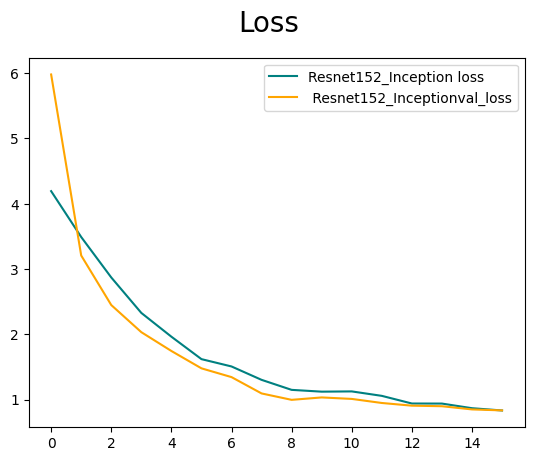

In [95]:
fig = plt.figure()
plt.plot(Resnet152_Inception_hist.history['loss'], color='teal', label='Resnet152_Inception loss')
plt.plot(Resnet152_Inception_hist.history['val_loss'], color='orange', label=' Resnet152_Inceptionval_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

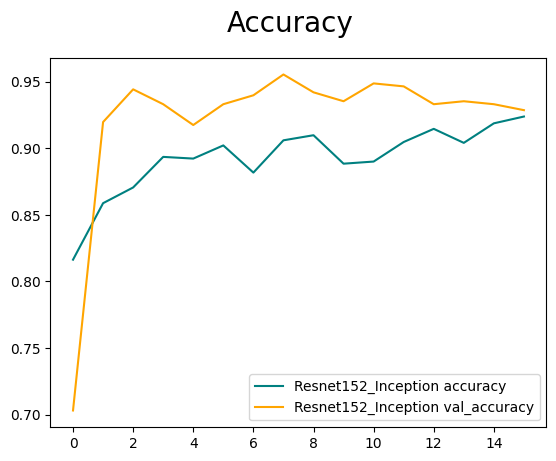

In [98]:
fig = plt.figure()
plt.plot(Resnet152_Inception_hist.history['accuracy'], color='teal', label='Resnet152_Inception accuracy')
plt.plot(Resnet152_Inception_hist.history['val_accuracy'], color='orange', label='Resnet152_Inception val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

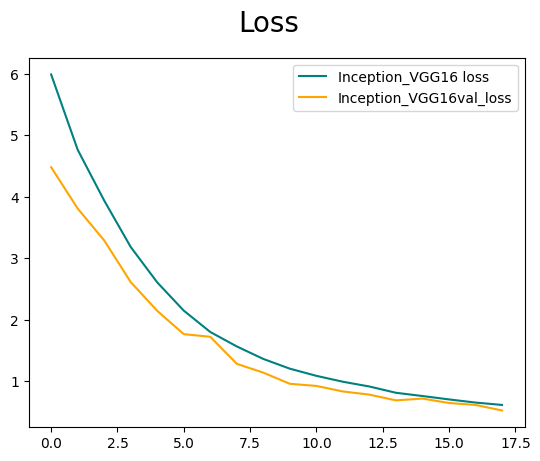

In [103]:
fig = plt.figure()
plt.plot(Inception_VGG16_hist.history['loss'], color='teal', label='Inception_VGG16 loss')
plt.plot(Inception_VGG16_hist.history['val_loss'], color='orange', label='Inception_VGG16val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

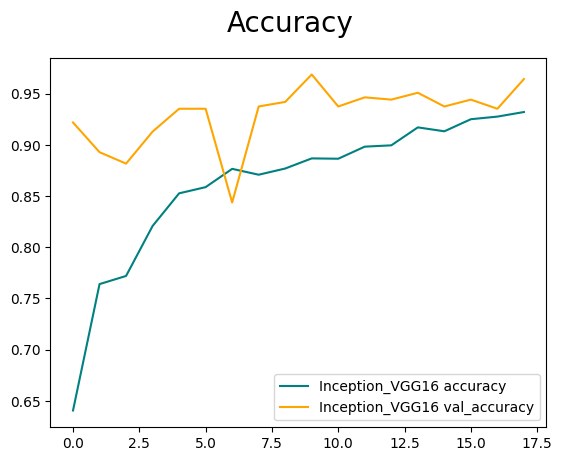

In [105]:
fig = plt.figure()
plt.plot(Inception_VGG16_hist.history['accuracy'], color='teal', label='Inception_VGG16 accuracy')
plt.plot(Inception_VGG16_hist.history['val_accuracy'], color='orange', label='Inception_VGG16 val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

10. Evaluate

In [101]:
# from tensorflow.keras.metrics import Precision, Recall, Accuracy
# pre = Precision()
# re = Recall()
# acc = Accuracy()
from sklearn.metrics import precision_recall_fscore_support as score

In [92]:
score = Resnet152_Inception_model.evaluate(test, verbose = 0) 

In [93]:
#test loss, test accuracy
print("loss: {}", score[0])
print("accuracy {}", score[1])

loss: {} 1.1886638402938843
accuracy {} 0.9331797361373901


In [102]:
from sklearn.metrics import precision_recall_fscore_support as score
y_pre = []
y_true = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = Resnet152_Inception_model.predict(X)
    for i in range(len(yhat)):
        y_pre.append(np.argmax(yhat[i]))
        y_true.append(y[i])
    # pre.update_state(y_true, y_pre)
    # re.update_state(y_true, y_pre)
    # acc.update_state(y_true, y_pre)

precision, recall, _, _ = score(y_true, y_pre)

print('Resnet152_Inception_precision: {}'.format(precision))
print('Resnet152_Inception_recall: {}'.format(recall))
        


1/1 [==============================] - 4s 4s/step
Resnet152_Inception_precision: [0.9245283  0.89175258 0.95555556 0.94092827]
Resnet152_Inception_recall: [0.95609756 0.96111111 0.88842975 0.9253112 ]


In [60]:
# accuracy: (tp + tn) / (p + n)
# precision tp / (tp + fp)
# recall: tp / (tp + fn)
# accuracy_result = acc.result()
# prediction_result = pre.result()
# recall_result = re.result()
# print('accuracy: {}',accuracy_result)
# print('prediction: {}',prediction_result)
# print('recall: {}',recall_result)

accuracy: {} tf.Tensor(0.93240917, shape=(), dtype=float32)
prediction: {} tf.Tensor(0.9924889, shape=(), dtype=float32)
recall: {} tf.Tensor(0.97414666, shape=(), dtype=float32)


In [86]:
# from tensorflow.keras.metrics import Precision, Recall, Accuracy
# pre = Precision()
# re = Recall()
# acc = Accuracy()

from sklearn.metrics import precision_recall_fscore_support as score

y_pre = []
y_true = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = Inception_VGG16_model.predict(X)
    for i in range(len(yhat)):
        y_pre.append(np.argmax(yhat[i]))
        y_true.append(y[i])
    # pre.update_state(y_true, y_pre)
    # re.update_state(y_true, y_pre)
    # acc.update_state(y_true, y_pre)
precision, recall, _, _ = score(y_true, y_pre)

print('Inception_VGG16_precision: {}'.format(precision))
print('Inception_VGG16_recall: {}'.format(recall))

1/1 [==============================] - 3s 3s/step
Inception_VGG16_precision: [0.93301435 0.92178771 0.91472868 0.97297297]
Inception_VGG16_recall: [0.95121951 0.92178771 0.94023904 0.92703863]


In [42]:
# accuracy_result = acc.result()
# prediction_result = pre.result()
# recall_result = re.result()
# print('accuracy: {}',accuracy_result)
# print('prediction: {}',prediction_result)
# print('recall: {}',recall_result)

accuracy: {} tf.Tensor(0.9481162, shape=(), dtype=float32)
prediction: {} tf.Tensor(0.99476004, shape=(), dtype=float32)
recall: {} tf.Tensor(0.98597693, shape=(), dtype=float32)


In [87]:
score = Inception_VGG16_model.evaluate(test, verbose = 0) 

In [88]:
#test loss, test accuracy
print("Inception_VGG16 loss: {}", score[0])
print("Inception_VGG16 accuracy {}", score[1])

loss: {} 0.9904528260231018
accuracy {} 0.9435483813285828


In [56]:
for i in range(0,30):
    print(y_true[i], y_pre[i])

1 1
0 0
0 0
2 2
0 0
1 1
3 3
0 0
0 0
1 1
0 0
1 1
2 2
2 2
0 0
0 0
1 1
2 2
2 2
0 0
0 0
2 2
0 0
2 2
1 1
1 1
2 2
3 3
1 1
3 3


11. Test

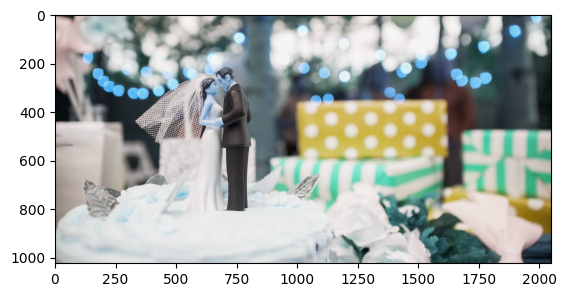

In [5]:
# import cv2
# from matplotlib import pyplot as plt
img = cv2.imread('D:/TLCN/check/wedding5.jpg')
plt.imshow(img.astype(int))

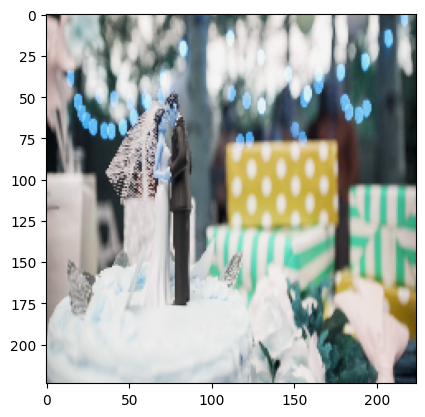

1/1 [==============================] - 3s 3s/step


In [9]:
# import tensorflow as tf
# import numpy as np
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()
# yhat = predict_model.predict(np.expand_dims(resize/255, 0))
yhat = loaded_model.predict(np.expand_dims(resize/255, 0))

In [10]:
np.argmax(yhat)

3

12. Save the Model

In [95]:
from tensorflow.keras.models import load_model
# VGG16_model.save(os.path.join('models','eventclassifierVGG16.h5'))

d:\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from tensorflow.keras.models import load_model
# loaded_model = load_model('./models/eventclassifier_InceptionV3_VGG16.h5')

13. Compare performance


13.1. Build Pretrained Resnet152 model

In [129]:
#Restnet152 
Resnet_Pretrained = ResNet152(weights='imagenet', include_top=False, input_tensor=input)
for layer in Resnet_Pretrained.layers:
    layer.trainable = False
#get base model output
pretrained1_output = Resnet_Pretrained.output
# flatten the output to a dimension
resnet152_flatten = Flatten()(pretrained1_output)
resnet152_fc1 = Dense(2048, activation='relu')(resnet152_flatten)
resnet152_dropout1 = Dropout(0.5)(resnet152_fc1)
resnet152_bn1 = BatchNormalization()(resnet152_dropout1)
resnet152_fc2 = Dense(2048, activation='relu')(resnet152_bn1)
resnet152_dropout2 = Dropout(0.5)(resnet152_fc2)
resnet152_output = Dense(4, activation='softmax')(resnet152_dropout2)

resnet_model = Model(inputs=input, outputs=resnet152_output)

In [130]:

resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
resnet_hist = resnet_model.fit(train, epochs=40, validation_data=val,callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8) )

Epoch 1/40
98/98 [==============================] - 628s 6s/step - loss: 1.8474 - accuracy: 0.2972 - val_loss: 1.6477 - val_accuracy: 0.4129
Epoch 2/40
98/98 [==============================] - 610s 6s/step - loss: 1.4653 - accuracy: 0.3288 - val_loss: 1.2890 - val_accuracy: 0.4732
Epoch 3/40
98/98 [==============================] - 617s 6s/step - loss: 1.3342 - accuracy: 0.3673 - val_loss: 1.2510 - val_accuracy: 0.5112
Epoch 4/40
98/98 [==============================] - 598s 6s/step - loss: 1.3236 - accuracy: 0.3632 - val_loss: 1.2446 - val_accuracy: 0.4844
Epoch 5/40
98/98 [==============================] - 597s 6s/step - loss: 1.3253 - accuracy: 0.3600 - val_loss: 1.2683 - val_accuracy: 0.5156
Epoch 6/40
98/98 [==============================] - 596s 6s/step - loss: 1.2947 - accuracy: 0.3842 - val_loss: 1.2892 - val_accuracy: 0.4196
Epoch 7/40
98/98 [==============================] - 599s 6s/step - loss: 1.2991 - accuracy: 0.3753 - val_loss: 1.2880 - val_accuracy: 0.3438
Epoch 8/40
98

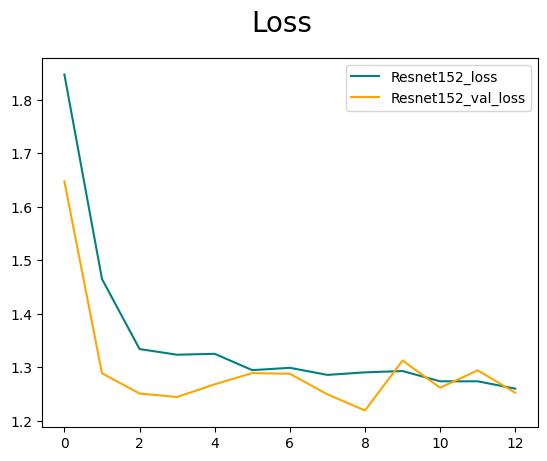

In [131]:
fig = plt.figure()
plt.plot(resnet_hist.history['loss'], color='teal', label='Resnet152_loss')
plt.plot(resnet_hist.history['val_loss'], color='orange', label='Resnet152_val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

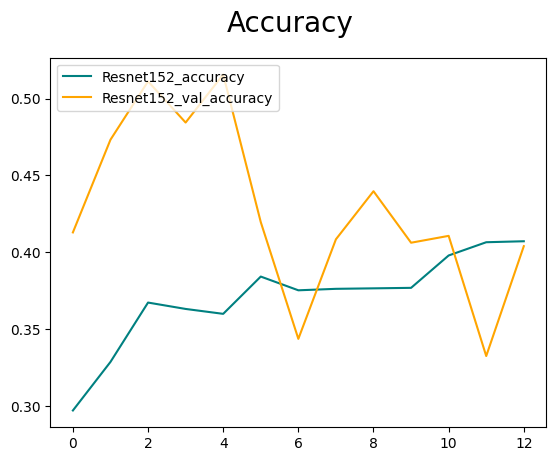

In [132]:
fig = plt.figure()
plt.plot(resnet_hist.history['accuracy'], color='teal', label='Resnet152_accuracy')
plt.plot(resnet_hist.history['val_accuracy'], color='orange', label='Resnet152_val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

13.2. Build Pretrained InceptionV3

In [107]:
#InceptionV3
Inception_Pretrained = InceptionV3(weights='imagenet', include_top=False, input_tensor=input)
for layer in Inception_Pretrained.layers:
    layer.trainable = False
#get base model output
pretrained2_output = Inception_Pretrained.output
# flatten the output to a dimension
inceptionv3_flatten = Flatten()(pretrained2_output)
inceptionv3_fc1 = Dense(2048, activation='relu')(inceptionv3_flatten)
inceptionv3_dropout1 = Dropout(0.5)(inceptionv3_fc1)
inceptionv3_fc2 = Dense(2048, activation='relu')(inceptionv3_dropout1)
inceptionv3_dropout2 = Dropout(0.5)(inceptionv3_fc2)
inceptionv3_output = Dense(4, activation='softmax')(inceptionv3_dropout2)

inception_model = Model(inputs=input, outputs=inceptionv3_output )

In [113]:
inception_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
inception_hist = inception_model.fit(train, epochs=40, validation_data=val, callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8))

Epoch 1/40
98/98 [==============================] - 217s 2s/step - loss: 12.3574 - accuracy: 0.6904 - val_loss: 0.4090 - val_accuracy: 0.8884
Epoch 2/40
98/98 [==============================] - 201s 2s/step - loss: 0.6508 - accuracy: 0.7816 - val_loss: 0.3215 - val_accuracy: 0.8996
Epoch 3/40
98/98 [==============================] - 200s 2s/step - loss: 0.7820 - accuracy: 0.7733 - val_loss: 0.2903 - val_accuracy: 0.8929
Epoch 4/40
98/98 [==============================] - 197s 2s/step - loss: 0.6213 - accuracy: 0.7870 - val_loss: 0.4108 - val_accuracy: 0.8817
Epoch 5/40
98/98 [==============================] - 196s 2s/step - loss: 0.6245 - accuracy: 0.8004 - val_loss: 0.3490 - val_accuracy: 0.9018
Epoch 6/40
98/98 [==============================] - 196s 2s/step - loss: 0.6270 - accuracy: 0.8023 - val_loss: 0.3039 - val_accuracy: 0.9062
Epoch 7/40
98/98 [==============================] - 197s 2s/step - loss: 0.6215 - accuracy: 0.8036 - val_loss: 0.2889 - val_accuracy: 0.8973
Epoch 8/40
9

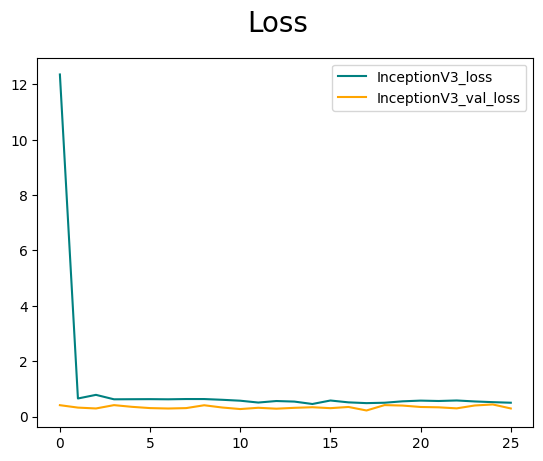

In [114]:
fig = plt.figure()
plt.plot(inception_hist.history['loss'], color='teal', label='InceptionV3_loss')
plt.plot(inception_hist.history['val_loss'], color='orange', label='InceptionV3_val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

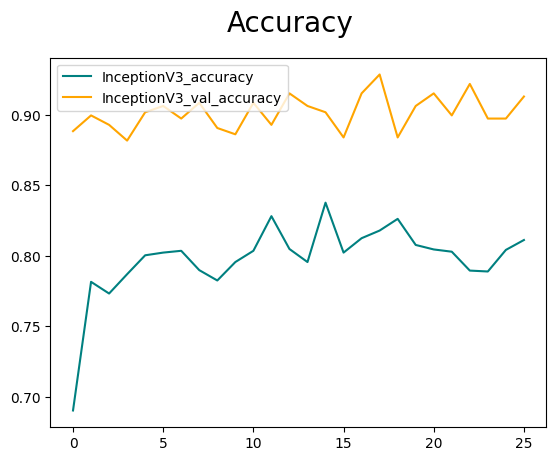

In [115]:
fig = plt.figure()
plt.plot(inception_hist.history['accuracy'], color='teal', label='InceptionV3_accuracy')
plt.plot(inception_hist.history['val_accuracy'], color='orange', label='InceptionV3_val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

13.3. Build VGG16 model

In [119]:
from tensorflow.keras.applications import VGG16
#VGG16
VGG16_Pretrained = VGG16(weights='imagenet', include_top=False, input_tensor=input)
for layer in VGG16_Pretrained.layers:
    layer.trainable = False
#get base model output
VGG16_output = VGG16_Pretrained.output
# flatten the output to a dimension
VGG16_flatten = Flatten()(VGG16_output)
VGG16_fc1 = Dense(2048, activation='relu')(VGG16_flatten)
VGG16_dropout1 = Dropout(0.5)(VGG16_fc1)
VGG16_fc2 = Dense(2048, activation='relu')(VGG16_dropout1)
VGG16_dropout2 = Dropout(0.5)(VGG16_fc2)
VGG16_output = Dense(4, activation='softmax')(VGG16_dropout2)

VGG16_model = Model(inputs=input, outputs=VGG16_output)

In [61]:
VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [120]:
VGG16_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
VGG16_hist = VGG16_model.fit(train, epochs=40, validation_data=val, callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=8))

Epoch 1/40


98/98 [==============================] - 315s 3s/step - loss: 2.2417 - accuracy: 0.5548 - val_loss: 0.4759 - val_accuracy: 0.8393
Epoch 2/40
98/98 [==============================] - 313s 3s/step - loss: 0.7957 - accuracy: 0.6936 - val_loss: 0.4432 - val_accuracy: 0.8237
Epoch 3/40
98/98 [==============================] - 314s 3s/step - loss: 0.7748 - accuracy: 0.7057 - val_loss: 0.4420 - val_accuracy: 0.8571
Epoch 4/40
98/98 [==============================] - 315s 3s/step - loss: 0.6974 - accuracy: 0.7270 - val_loss: 0.3581 - val_accuracy: 0.8973
Epoch 5/40
98/98 [==============================] - 315s 3s/step - loss: 0.7130 - accuracy: 0.7194 - val_loss: 0.3466 - val_accuracy: 0.8839
Epoch 6/40
98/98 [==============================] - 314s 3s/step - loss: 0.6869 - accuracy: 0.7293 - val_loss: 0.3764 - val_accuracy: 0.8862
Epoch 7/40
98/98 [==============================] - 315s 3s/step - loss: 0.6650 - accuracy: 0.7420 - val_loss: 0.3195 - val_accuracy: 0.8973
Epoch 8/40
98/98 [======

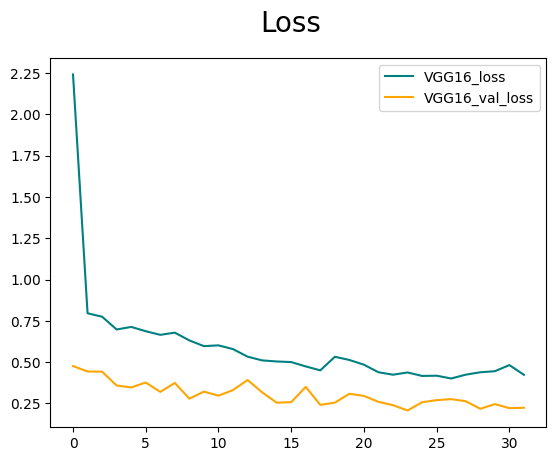

In [121]:
fig = plt.figure()
plt.plot(VGG16_hist.history['loss'], color='teal', label='VGG16_loss')
plt.plot(VGG16_hist.history['val_loss'], color='orange', label='VGG16_val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

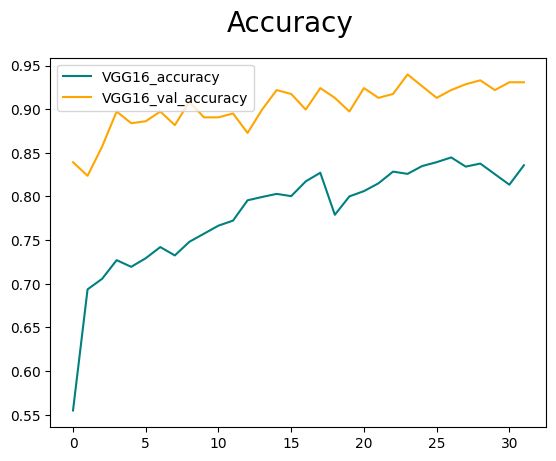

In [122]:
fig = plt.figure()
plt.plot(VGG16_hist.history['accuracy'], color='teal', label='VGG16_accuracy')
plt.plot(VGG16_hist.history['val_accuracy'], color='orange', label='VGG16_val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

13.4. Plot performance of models

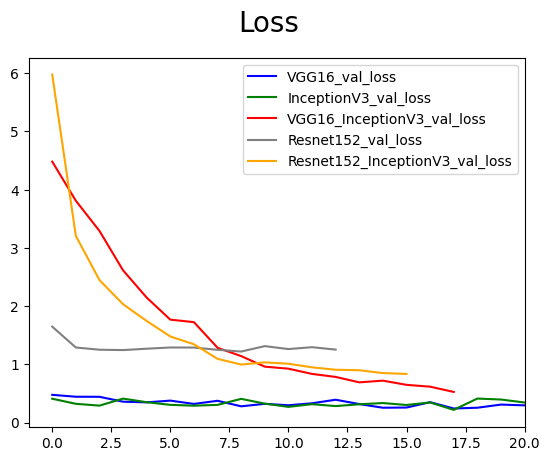

In [144]:
fig = plt.figure()
plt.plot(VGG16_hist.history['val_loss'], color='blue', label='VGG16_val_loss')
plt.plot(inception_hist.history['val_loss'], color='green', label='InceptionV3_val_loss')
plt.plot(Inception_VGG16_hist.history['val_loss'], color='red', label='VGG16_InceptionV3_val_loss')
plt.plot(resnet_hist.history['val_loss'], color='gray', label='Resnet152_val_loss')
plt.plot(Resnet152_Inception_hist.history['val_loss'], color='orange', label='Resnet152_InceptionV3_val_loss')
plt.xlim(-1,20)
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

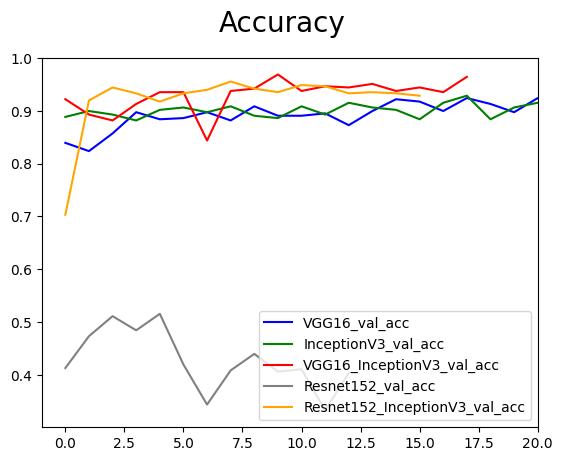

In [145]:
fig = plt.figure()
plt.plot(VGG16_hist.history['val_accuracy'], color='blue', label='VGG16_val_acc')
plt.plot(inception_hist.history['val_accuracy'], color='green', label='InceptionV3_val_acc')
plt.plot(Inception_VGG16_hist.history['val_accuracy'], color='red', label='VGG16_InceptionV3_val_acc')
plt.plot(resnet_hist.history['val_accuracy'], color='gray', label='Resnet152_val_acc')
plt.plot(Resnet152_Inception_hist.history['val_accuracy'], color='orange', label='Resnet152_InceptionV3_val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.xlim(-1,20)
plt.legend(loc="lower right")
plt.show()

13.5. Evaluate Resnet152 and InceptionV3, VGG16

In [118]:
inception_score = inception_model.evaluate(test, verbose = 0) 
#test loss, test accuracy
print("inceptionV3_loss: {}", inception_score[0])
print("inceptionV3_accuracy {}", inception_score[1])

inceptionV3_loss: {} 0.36684462428092957
inceptionV3_accuracy {} 0.8997696042060852


In [142]:
resnet_score = resnet_model.evaluate(test, verbose = 0) 
#test loss, test accuracy
print("resnet152_loss: {}", resnet_score[0])
print("resnet152_accuracy {}", resnet_score[1])

resnet152_loss: {} 1.2001752853393555
resnet152_accuracy {} 0.4285714328289032


In [127]:
VGG16_score = VGG16_model.evaluate(test, verbose = 0) 
#test loss, test accuracy
print("VGG16_loss: {}", VGG16_score[0])
print("VGG16_accuracy {}", VGG16_score[1])

VGG16_loss: {} 0.2797131836414337
VGG16_accuracy {} 0.9089861512184143


In [143]:
# pre = Precision()
# re = Recall()
# acc = Accuracy()
from sklearn.metrics import precision_recall_fscore_support as score
y_pre = []
y_true = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = resnet_model.predict(X)
    for i in range(len(yhat)):
        y_pre.append(np.argmax(yhat[i]))
        y_true.append(y[i])
    # pre.update_state(y_true, y_pre)
    # re.update_state(y_true, y_pre)
    # acc.update_state(y_true, y_pre)
precision, recall, _, _ = score(y_true, y_pre)

print('Resnet152_precision: {}'.format(precision))
print('Resnet152_recall: {}'.format(recall))

1/1 [==============================] - 5s 5s/step
Resnet152_precision: [0.60714286 0.51388889 0.77692308 0.34012539]
Resnet152_recall: [0.0821256  0.20555556 0.41056911 0.92340426]


In [76]:
# resnet152_acc = acc.result()
# resnet152_pre = pre.result()
# resnet152_re = re.result()
# print('resnet152_accuracy: {}',resnet152_acc)
# print('resnet152_prediction: {}',resnet152_pre)
# print('resnet152_recall: {}',resnet152_re)

resnet152_accuracy: {} tf.Tensor(0.44585255, shape=(), dtype=float32)
resnet152_prediction: {} tf.Tensor(0.8200837, shape=(), dtype=float32)
resnet152_recall: {} tf.Tensor(0.875, shape=(), dtype=float32)


In [116]:
# pre = Precision()
# re = Recall()
# acc = Accuracy()
from sklearn.metrics import precision_recall_fscore_support as score
y_pre = []
y_true = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = inception_model.predict(X)
    for i in range(len(yhat)):
        y_pre.append(np.argmax(yhat[i]))
        y_true.append(y[i])
    # pre.update_state(y_true, y_pre)
    # re.update_state(y_true, y_pre)
    # acc.update_state(y_true, y_pre)
precision, recall, _, _ = score(y_true, y_pre)

print('InceptionV3_precision: {}'.format(precision))
print('InceptionV3_recall: {}'.format(recall))

1/1 [==============================] - 1s 602ms/step
InceptionV3_precision: [0.79215686 0.97101449 0.91338583 0.9638009 ]
InceptionV3_recall: [0.97115385 0.75706215 0.92063492 0.92207792]


In [ ]:
# inceptionV3_acc = acc.result()
# inceptionV3_pre = pre.result()
# inceptionV3_re = re.result()
# print('inceptionV3_accuracy: {}',inceptionV3_acc)
# print('inceptionV3_prediction: {}',inceptionV3_pre)
# print('inceptionV3_recall: {}',inceptionV3_re)

inceptionV3_accuracy: {} tf.Tensor(0.8867833, shape=(), dtype=float32)
inceptionV3_prediction: {} tf.Tensor(0.9946613, shape=(), dtype=float32)
inceptionV3_recall: {} tf.Tensor(0.8803948, shape=(), dtype=float32)


In [128]:
# pre = Precision()
# re = Recall()
# acc = Accuracy()
from sklearn.metrics import precision_recall_fscore_support as score
y_pre = []
y_true = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = VGG16_model.predict(X)
    for i in range(len(yhat)):
        y_pre.append(np.argmax(yhat[i]))
        y_true.append(y[i])
    # pre.update_state(y_true, y_pre)
    # re.update_state(y_true, y_pre)
    # acc.update_state(y_true, y_pre)
precision, recall, _, _ = score(y_true, y_pre)

print('VGG16_precision: {}'.format(precision))
print('VGG16_recall: {}'.format(recall))

1/1 [==============================] - 2s 2s/step
VGG16_precision: [0.90865385 0.94152047 0.87732342 0.94090909]
VGG16_recall: [0.93564356 0.87978142 0.94023904 0.89224138]


In [27]:
# VGG16_acc = acc.result()
# VGG16_pre = pre.result()
# VGG16_re = re.result()
# print('VGG16_accuracy: {}',VGG16_acc)
# print('VGG16_prediction: {}',VGG16_pre)
# print('VGG16_recall: {}',VGG16_re)

VGG16_accuracy: {} tf.Tensor(0.9076674, shape=(), dtype=float32)
VGG16_prediction: {} tf.Tensor(0.9722386, shape=(), dtype=float32)
VGG16_recall: {} tf.Tensor(0.9819049, shape=(), dtype=float32)
